In [ ]:
# Import
import torch
import torchvision

from google.colab import drive
import os

drive.mount('/content/drive')

print("\n" + "="*70)
print("GPU CHECK")
print("="*70 + "\n")

if not torch.cuda.is_available():
    print("❌ ERROR: NO GPU DETECTED!")
    print("\n🔧 FIX THIS:")
    print("   1. Go to: Runtime → Change runtime type")
    print("   2. Select: T4 GPU")
    print("   3. Click: Save")
    print("   4. Re-run this cell")
    print("\n⚠️  Mask2Former REQUIRES GPU and will NOT work on CPU!")
    raise RuntimeError("GPU required but not available")
else:
    print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")
    print(f"   PyTorch: {torch.__version__}")
    print(f"   Torchvision: {torchvision.__version__}")

WORK_DIR = "/content/drive/MyDrive/mask2former_task"
os.chdir('/content')

print(f"\n✅ Working directory: {WORK_DIR}")
print(f"✅ Files found:")
print(f"   - Preprocessed data: {os.path.exists(f'{WORK_DIR}/preprocessed_data')}")
print(f"   - COCO format: {os.path.exists(f'{WORK_DIR}/coco_format')}")


# Install Dependencies

print("\n" + "="*70)
print("INSTALLING DEPENDENCIES")
print("="*70 + "\n")

import torch
print(f"📦 Using Colab's PyTorch: {torch.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")

print("\n📦 Building Detectron2 from source...")
print("   This ensures compatibility with PyTorch 2.9")
print("   Will take ~3-5 minutes...")

!pip uninstall -y detectron2 2>/dev/null

!pip install -q opencv-python-headless timm einops scipy

# Clone and build detectron2
import subprocess
import sys

result = subprocess.run([
    sys.executable, '-m', 'pip', 'install', '-q',
    'git+https://github.com/facebookresearch/detectron2.git'
], capture_output=True, text=True)

if result.returncode == 0:
    print("✅ Detectron2 built successfully!")
else:
    print("⚠️  Standard build had warnings, trying alternative method...")
    !pip install -q --no-build-isolation 'git+https://github.com/facebookresearch/detectron2.git'
    print("✅ Detectron2 installed!")

print("\n✅ All dependencies installed!")

# Verify detectron2 works
print("\n🔍 Verifying Detectron2...")
try:
    import detectron2
    from detectron2 import model_zoo
    print("✅ Detectron2 imported successfully!")
    print(f"   Version: {detectron2.__version__}")
except Exception as e:
    print(f"❌ Detectron2 import failed: {e}")
    print("\n⚠️  Will try to continue anyway...")


# Clone and Setup Mask2Former

print("\n" + "="*70)
print("SETTING UP MASK2FORMER")
print("="*70 + "\n")

if os.path.exists('/content/Mask2Former'):
    print("⚠️  Removing previous Mask2Former installation...")
    !rm -rf /content/Mask2Former

print("📥 Cloning Mask2Former repository...")
!git clone https://github.com/facebookresearch/Mask2Former.git
os.chdir('/content/Mask2Former')

print("\n📦 Installing Mask2Former requirements...")
!pip install -q -r requirements.txt

print("\n🔧 Applying PyTorch 2.x compatibility fix...")
cuda_file = "/content/Mask2Former/mask2former/modeling/pixel_decoder/ops/src/cuda/ms_deform_attn_cuda.cu"

with open(cuda_file, 'r') as f:
    lines = f.readlines()

# Fix the code
fixed_lines = []
for line in lines:
    # Fix 1: Replace value.type() with value.scalar_type()
    if 'AT_DISPATCH_FLOATING_TYPES' in line and 'value.type()' in line:
        line = line.replace('value.type()', 'value.scalar_type()')

    # Fix 2: Replace value.scalar_type().is_cuda() with value.is_cuda()
    if 'value.scalar_type().is_cuda()' in line:
        line = line.replace('value.scalar_type().is_cuda()', 'value.is_cuda()')

    # Fix 3: Same for grad_output_g
    if 'grad_output_g.type()' in line:
        line = line.replace('grad_output_g.type()', 'grad_output_g.scalar_type()')

    if 'grad_output_g.scalar_type().is_cuda()' in line:
        line = line.replace('grad_output_g.scalar_type().is_cuda()', 'grad_output_g.is_cuda()')

    fixed_lines.append(line)

# Write back
with open(cuda_file, 'w') as f:
    f.writelines(fixed_lines)

print("✅ Compatibility fixes applied!")

# Now compile CUDA kernels
print("\n🔨 Compiling CUDA kernels (this takes 3-5 minutes)...")
print("    Please wait patiently...")
os.chdir('/content/Mask2Former/mask2former/modeling/pixel_decoder/ops')

# Compile with proper error handling
import subprocess
result = subprocess.run(['python', 'setup.py', 'build', 'install'],
                       capture_output=True, text=True)

if result.returncode != 0:
    print("\n❌ CUDA compilation failed!")
    print("Error output:")
    print(result.stderr)
    raise RuntimeError("CUDA kernel compilation failed")
else:
    print("✅ CUDA kernels compiled successfully!")

os.chdir('/content')
print("\n✅ Mask2Former setup complete!")

# Verify the module can be imported
print("\n🔍 Verifying CUDA module...")
try:
    import MultiScaleDeformableAttention
    print("✅ MultiScaleDeformableAttention module imported successfully!")
except ImportError as e:
    print("⚠️  Module import issue, trying to fix...")
    # The .egg file needs to be in sys.path
    import sys
    import glob
    egg_files = glob.glob('/usr/local/lib/python3.12/dist-packages/MultiScaleDeformableAttention*.egg')
    if egg_files:
        sys.path.insert(0, egg_files[0])
        print(f"   Added: {egg_files[0]}")
        import MultiScaleDeformableAttention
        print("✅ Module now accessible!")
    else:
        print(f"❌ Could not find compiled module: {e}")
        raise


# Create Small Test Dataset

print("\n" + "="*70)
print("CREATING SMALL TEST DATASET")
print("="*70 + "\n")

import json

SMALL_DATASET_DIR = "/content/small_dataset"
os.makedirs(SMALL_DATASET_DIR, exist_ok=True)

def create_small_dataset(original_json, num_images=10):
    """Create a tiny dataset for quick testing"""
    with open(original_json, 'r') as f:
        coco_data = json.load(f)

    small_images = coco_data['images'][:num_images]
    image_ids = [img['id'] for img in small_images]

    small_annotations = [
        ann for ann in coco_data['annotations']
        if ann['image_id'] in image_ids
    ]

    small_coco = {
        "info": coco_data['info'],
        "licenses": coco_data['licenses'],
        "categories": coco_data['categories'],
        "images": small_images,
        "annotations": small_annotations
    }

    print(f"   Selected {len(small_images)} images, {len(small_annotations)} annotations")
    return small_coco

# Create small train set (10 images for quick test)
print("📦 Creating small training set (10 images)...")
small_train = create_small_dataset(
    f"{WORK_DIR}/coco_format/instances_train.json", 10
)
small_train_json = f"{SMALL_DATASET_DIR}/instances_train_small.json"
with open(small_train_json, 'w') as f:
    json.dump(small_train, f)

# Create small val set (3 images)
print("📦 Creating small validation set (3 images)...")
small_val = create_small_dataset(
    f"{WORK_DIR}/coco_format/instances_val.json", 3
)
small_val_json = f"{SMALL_DATASET_DIR}/instances_val_small.json"
with open(small_val_json, 'w') as f:
    json.dump(small_val, f)

print(f"\n✅ Small dataset created for testing!")


# Dataset Registration

print("\n" + "="*70)
print("REGISTERING DATASETS")
print("="*70 + "\n")

import sys
sys.path.insert(0, '/content/Mask2Former')

# Import detectron2 (torch/torchvision already imported in Cell 1)
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

TRAIN_DATASET_NAME = "tree_train_small"
VAL_DATASET_NAME = "tree_val_small"

# Register datasets
register_coco_instances(
    TRAIN_DATASET_NAME, {},
    small_train_json,
    f"{WORK_DIR}/preprocessed_data/train_PNG"
)
print(f"✅ Registered: {TRAIN_DATASET_NAME}")

register_coco_instances(
    VAL_DATASET_NAME, {},
    small_val_json,
    f"{WORK_DIR}/preprocessed_data/val_PNG"
)
print(f"✅ Registered: {VAL_DATASET_NAME}")

# Set metadata
metadata = {"thing_classes": ["tree"], "thing_colors": [(34, 139, 34)]}
MetadataCatalog.get(TRAIN_DATASET_NAME).set(**metadata)
MetadataCatalog.get(VAL_DATASET_NAME).set(**metadata)

train_dicts = DatasetCatalog.get(TRAIN_DATASET_NAME)
val_dicts = DatasetCatalog.get(VAL_DATASET_NAME)
print(f"\n📊 Dataset: {len(train_dicts)} train, {len(val_dicts)} val images")


Mounted at /content/drive

GPU CHECK

✅ GPU Available: Tesla T4
   Memory: 15.83 GB
   CUDA Version: 12.6
   PyTorch: 2.8.0+cu126
   Torchvision: 0.23.0+cu126

✅ Working directory: /content/drive/MyDrive/mask2former_task
✅ Files found:
   - Preprocessed data: True
   - COCO format: True

INSTALLING DEPENDENCIES

📦 Using Colab's PyTorch: 2.8.0+cu126
   CUDA available: True

📦 Building Detectron2 from source...
   This ensures compatibility with PyTorch 2.9
   Will take ~3-5 minutes...
✅ Detectron2 built successfully!

✅ All dependencies installed!

🔍 Verifying Detectron2...
✅ Detectron2 imported successfully!
   Version: 0.6

SETTING UP MASK2FORMER

📥 Cloning Mask2Former repository...
Cloning into 'Mask2Former'...
remote: Enumerating objects: 297, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 297 (delta 118), reused 111 (delta 111), pack-reused 84 (from 1)
Receiving objects: 100% (297/297), 408.25 KiB | 2.16 MiB/s,

In [ ]:
# Configure Mask2Former

print("\n" + "="*70)
print("CONFIGURING MASK2FORMER")
print("="*70 + "\n")

from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from mask2former import add_maskformer2_config

OUTPUT_DIR = f"{WORK_DIR}/output_test_gpu"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Initialize config
cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)

# Load base config
os.chdir('/content/Mask2Former')
cfg.merge_from_file(
    "configs/coco/instance-segmentation/maskformer2_R50_bs16_50ep.yaml"
)

# Dataset configuration
cfg.DATASETS.TRAIN = (TRAIN_DATASET_NAME,)
cfg.DATASETS.TEST = (VAL_DATASET_NAME,)
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 1
cfg.MODEL.MASK_FORMER.NUM_OBJECT_QUERIES = 50

# Model - train from scratch (no pretrained weights)
cfg.MODEL.WEIGHTS = ""
cfg.MODEL.DEVICE = "cuda"

# MINIMAL training settings for quick test
cfg.SOLVER.IMS_PER_BATCH = 2  # Small batch for T4 GPU
cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 100  # Very short test (10 images, 100 iters ≈ 5 epochs)
cfg.SOLVER.STEPS = (70, 90)
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 20

cfg.SOLVER.CHECKPOINT_PERIOD = 50
cfg.TEST.EVAL_PERIOD = 50

# Gradient clipping
cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 0.01
cfg.SOLVER.CLIP_GRADIENTS.NORM_TYPE = 2.0

# Keep AMP enabled for GPU (faster)
cfg.SOLVER.AMP.ENABLED = True

# CRITICAL FIX: Enable mask conversion in data loader
cfg.INPUT.MASK_FORMAT = "bitmask"  # Convert polygon masks to bitmasks
cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = False
cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = False

# Fix for evaluation with small dataset
cfg.MODEL.MASK_FORMER.TEST.OBJECT_MASK_THRESHOLD = 0.0
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.0
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0

# Fix the topk issue for small validation set
# The validation set has very few predictions, so reduce topk
cfg.TEST.DETECTIONS_PER_IMAGE = 10  # Reduce from default 100

# Disable evaluation completely for this quick test
cfg.TEST.EVAL_PERIOD = 0  # 0 = disable evaluation entirely

# Smaller image size for faster training
cfg.INPUT.MIN_SIZE_TRAIN = (512,)
cfg.INPUT.MAX_SIZE_TRAIN = 512
cfg.INPUT.MIN_SIZE_TEST = 512
cfg.INPUT.MAX_SIZE_TEST = 512
cfg.INPUT.RANDOM_FLIP = "horizontal"

cfg.OUTPUT_DIR = OUTPUT_DIR

# Save config
with open(os.path.join(OUTPUT_DIR, "config.yaml"), "w") as f:
    f.write(cfg.dump())

print("✅ Configuration complete!")
print(f"\n📊 Test Configuration:")
print(f"   Device: {cfg.MODEL.DEVICE}")
print(f"   Dataset: {len(train_dicts)} train images")
print(f"   Iterations: {cfg.SOLVER.MAX_ITER} (QUICK TEST)")
print(f"   Batch size: {cfg.SOLVER.IMS_PER_BATCH}")
print(f"   Image size: {cfg.INPUT.MIN_SIZE_TRAIN[0]}")
print(f"   Estimated time: ~5-10 minutes")
print(f"\n⚠️  Training from scratch (no pretrained weights)")
print(f"⚠️  This is just to verify the pipeline works!")


# Initialize Trainer

print("\n" + "="*70)
print("INITIALIZING TRAINER")
print("="*70 + "\n")

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data import transforms as T
import copy

class Mask2FormerTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, output_dir=output_folder, tasks=("segm",))

    @classmethod
    def build_train_loader(cls, cfg):
        # Custom mapper that converts masks properly
        from detectron2.structures import BitMasks, Instances
        import torch

        def custom_mapper(dataset_dict):
            # Call default mapper
            mapper = DatasetMapper(
                cfg,
                is_train=True,
                augmentations=[
                    T.ResizeShortestEdge(
                        cfg.INPUT.MIN_SIZE_TRAIN,
                        cfg.INPUT.MAX_SIZE_TRAIN,
                        "choice"
                    ),
                    T.RandomFlip(),
                ],
                image_format=cfg.INPUT.FORMAT,
                use_instance_mask=True,
                instance_mask_format="bitmask"
            )

            dataset_dict = mapper(dataset_dict)

            # Convert BitMasks to tensor
            if "instances" in dataset_dict:
                instances = dataset_dict["instances"]
                if hasattr(instances, "gt_masks") and isinstance(instances.gt_masks, BitMasks):
                    instances.gt_masks = instances.gt_masks.tensor

            return dataset_dict

        return build_detection_train_loader(cfg, mapper=custom_mapper)

trainer = Mask2FormerTrainer(cfg)
trainer.resume_or_load(resume=False)

print("✅ Trainer initialized!")
print(f"📊 Ready to train on {torch.cuda.get_device_name(0)}")


# START TRAINING 🚀

print("\n" + "="*70)
print("🚀 STARTING TEST TRAINING")
print("="*70 + "\n")

print("⏱️  Estimated time: 5-10 minutes on T4 GPU")
print("📊 This is a quick test with 10 images, 100 iterations")
print("🔍 Watch for the loss decreasing...\n")
print("="*70 + "\n")

import time
start_time = time.time()

try:
    trainer.train()

    elapsed_time = time.time() - start_time

    print("\n" + "="*70)
    print("✅ TEST TRAINING COMPLETE!")
    print("="*70)
    print(f"\n⏱️  Time taken: {elapsed_time/60:.1f} minutes")
    print(f"📁 Model saved to: {OUTPUT_DIR}")
    print("\n✅ Pipeline verification successful!")
    print("\n🎯 Next steps:")
    print("   1. Review the training loss (should decrease)")
    print("   2. Check model files were created")
    print("   3. Scale up to full dataset and more iterations")
    print("="*70 + "\n")

except Exception as e:
    print(f"\n\n❌ Training failed: {str(e)}")
    raise




CONFIGURING MASK2FORMER



/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/content/Mask2Former/mask2former/modeling/pixel_decoder/ops/modules/ms_deform_attn.py:87: SyntaxWarning: invalid escape sequence '\s'
  :param input_flatten               (N, \sum_{l=0}^{L-1} H_l \cdot W_l, C)
/content/Mask2Former/mask2former/modeling/pixel_decoder/msdeformattn.py:314: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)


✅ Configuration complete!

📊 Test Configuration:
   Device: cuda
   Dataset: 10 train images
   Iterations: 100 (QUICK TEST)
   Batch size: 2
   Image size: 512
   Estimated time: ~5-10 minutes

⚠️  Training from scratch (no pretrained weights)
⚠️  This is just to verify the pipeline works!

INITIALIZING TRAINER

[10/26 09:02:22 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:474: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()


[10/26 09:02:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/data/detection_utils.py:449: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])


[10/26 09:02:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):


[10/26 09:02:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/data/detection_utils.py:449: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)`

[10/26 09:02:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:41 d2.utils.events]:  eta: 0:00:35  iter: 19  total_loss: 95.24  loss_ce: 1.333  loss_mask: 2.914  loss_dice: 4.889  loss_ce_0: 1.47  loss_mask_0: 1.342  loss_dice_0: 4.836  loss_ce_1: 1.718  loss_mask_1: 1.577  loss_dice_1: 4.863  loss_ce_2: 1.768  loss_mask_2: 2.402  loss_dice_2: 4.863  loss_ce_3: 1.473  loss_mask_3: 3.351  loss_dice_3: 4.884  loss_ce_4: 1.31  loss_mask_4: 3.39  loss_dice_4: 4.877  loss_ce_5: 1.298  loss_mask_5: 2.258  loss_dice_5: 4.873  loss_ce_6: 1.329  loss_mask_6: 4.701  loss_dice_6: 4.848  loss_ce_7: 1.572  loss_mask_7: 6.123  loss_dice_7: 4.848  loss_ce_8: 1.406  loss_mask_8: 3.851  loss_dice_8: 4.879    time: 0.4492  last_time: 0.4427  data_time: 0.2486  last_data_time: 0.0060   lr: 0.0001  max_mem: 2219M
[10/26 09:02:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:46 d2.data.dataset_mapper]: [DatasetMapper] A

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:56 d2.utils.events]:  eta: 0:00:27  iter: 39  total_loss: 93.95  loss_ce: 1.332  loss_mask: 2.801  loss_dice: 4.907  loss_ce_0: 1.468  loss_mask_0: 1.322  loss_dice_0: 4.87  loss_ce_1: 1.729  loss_mask_1: 1.486  loss_dice_1: 4.886  loss_ce_2: 1.746  loss_mask_2: 2.284  loss_dice_2: 4.884  loss_ce_3: 1.467  loss_mask_3: 3.29  loss_dice_3: 4.92  loss_ce_4: 1.302  loss_mask_4: 3.339  loss_dice_4: 4.868  loss_ce_5: 1.296  loss_mask_5: 2.077  loss_dice_5: 4.888  loss_ce_6: 1.325  loss_mask_6: 4.523  loss_dice_6: 4.853  loss_ce_7: 1.573  loss_mask_7: 5.736  loss_dice_7: 4.861  loss_ce_8: 1.406  loss_mask_8: 3.763  loss_dice_8: 4.883    time: 0.4711  last_time: 0.6102  data_time: 0.0090  last_data_time: 0.0058   lr: 0.0001  max_mem: 2219M
[10/26 09:02:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:56 d2.data.dataset_mapper]: [DatasetMapper] A

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:02:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:02:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:16 d2.utils.events]:  eta: 0:00:18  iter: 59  total_loss: 92.02  loss_ce: 1.325  loss_mask: 2.611  loss_dice: 4.889  loss_ce_0: 1.388  loss_mask_0: 1.363  loss_dice_0: 4.878  loss_ce_1: 1.716  loss_mask_1: 1.444  loss_dice_1: 4.874  loss_ce_2: 1.732  loss_mask_2: 2.091  loss_dice_2: 4.86  loss_ce_3: 1.476  loss_mask_3: 3.131  loss_dice_3: 4.894  loss_ce_4: 1.317  loss_mask_4: 3.222  loss_dice_4: 4.855  loss_ce_5: 1.304  loss_mask_5: 1.825  loss_dice_5: 4.882  loss_ce_6: 1.328  loss_mask_6: 4.358  loss_dice_6: 4.894  loss_ce_7: 1.571  loss_mask_7: 5.294  loss_dice_7: 4.898  loss_ce_8: 1.402  loss_mask_8: 3.645  loss_dice_8: 4.914    time: 0.5003  last_time: 0.5680  data_time: 0.0083  last_data_time: 0.0081   lr: 0.0001  max_mem: 2219M
[10/26 09:03:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:16 d2.data.dataset_mapper]: [DatasetMapper]

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:34 d2.utils.events]:  eta: 0:00:09  iter: 79  total_loss: 90.56  loss_ce: 1.321  loss_mask: 2.433  loss_dice: 4.905  loss_ce_0: 1.376  loss_mask_0: 1.379  loss_dice_0: 4.857  loss_ce_1: 1.7  loss_mask_1: 1.351  loss_dice_1: 4.877  loss_ce_2: 1.731  loss_mask_2: 1.928  loss_dice_2: 4.866  loss_ce_3: 1.486  loss_mask_3: 2.965  loss_dice_3: 4.91  loss_ce_4: 1.313  loss_mask_4: 3.059  loss_dice_4: 4.85  loss_ce_5: 1.302  loss_mask_5: 1.605  loss_dice_5: 4.872  loss_ce_6: 1.33  loss_mask_6: 4.16  loss_dice_6: 4.881  loss_ce_7: 1.568  loss_mask_7: 4.922  loss_dice_7: 4.875  loss_ce_8: 1.401  loss_mask_8: 3.569  loss_dice_8: 4.892    time: 0.6016  last_time: 0.6183  data_time: 0.4027  last_data_time: 0.0144   lr: 1e-05  max_mem: 2219M
[10/26 09:03:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:34 d2.data.dataset_mapper]: [DatasetMapper] Augme

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:03:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/26 09:03:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/26 09:04:13 d2.utils.events]:  eta: 0:00:00  iter: 99  total_loss: 90.05  loss_ce: 1.317  loss_mask: 2.423  loss_dice: 4.896  loss_ce_0: 1.365  loss_mask_0: 1.396  loss_dice_0: 4.852  loss_ce_1: 1.713  loss_mask_1: 1.372  loss_dice_1: 4.869  loss_ce_2: 1.74  loss_mask_2: 1.896  loss_dice_2: 4.843  loss_ce_3: 1.484  loss_mask_3: 2.884  loss_dice_3: 4.853  loss_ce_4: 1.312  loss_mask_4: 3  loss_dice_4: 4.799  loss_ce_5: 1.304  loss_mask_5: 1.56  loss_dice_5: 4.838  loss_ce_6: 1.321  loss_mask_6: 4.128  loss_dice_6: 4.879  loss_ce_7: 1.566  loss_mask_7: 4.813  loss_dice_7: 4.862  loss_ce_8: 1.401  loss_mask_8: 3.548  loss_dice_8: 4.906    time: 0.5851  last_time: 0.4529  data_time: 0.0098  last_data_time: 0.0107   lr: 1e-06  max_mem: 2220M
[10/26 09:04:13 d2.engine.hooks]: Overall training speed: 98 iterations in 0:00:57 (0.5852 s / it)
[10/26 09:04:13 d2.engine.hooks]: Total training time: 0:01:39 (0:00:42 on hooks)
[10/26 09:04:13 d2.data.datasets.coco]: Loaded 3 images in COCO form


VERIFYING OUTPUT

📁 Checking output files...
   ✅ model_final.pth (335.83 MB)
   ✅ config.yaml (0.01 MB)
   ✅ metrics.json (0.01 MB)

🎉 PIPELINE TEST COMPLETE!

✅ What we verified:
   ✓ GPU is working
   ✓ Mask2Former compiles on GPU
   ✓ Dataset loads correctly
   ✓ Training loop runs without errors
   ✓ Model checkpoints save properly

🚀 READY FOR FULL TRAINING!

📋 To train the real model:
   1. Use full dataset (487 train, 165 val)
   2. Train for 10,000 iterations
   3. Use batch size 4-8
   4. Use image size 1024x1024
   5. Load pretrained COCO weights
   6. Expected time: 6-8 hours on T4 GPU


SAMPLE PREDICTIONS

[10/26 09:04:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/mask2former_task/output_test_gpu/model_final.pth ...


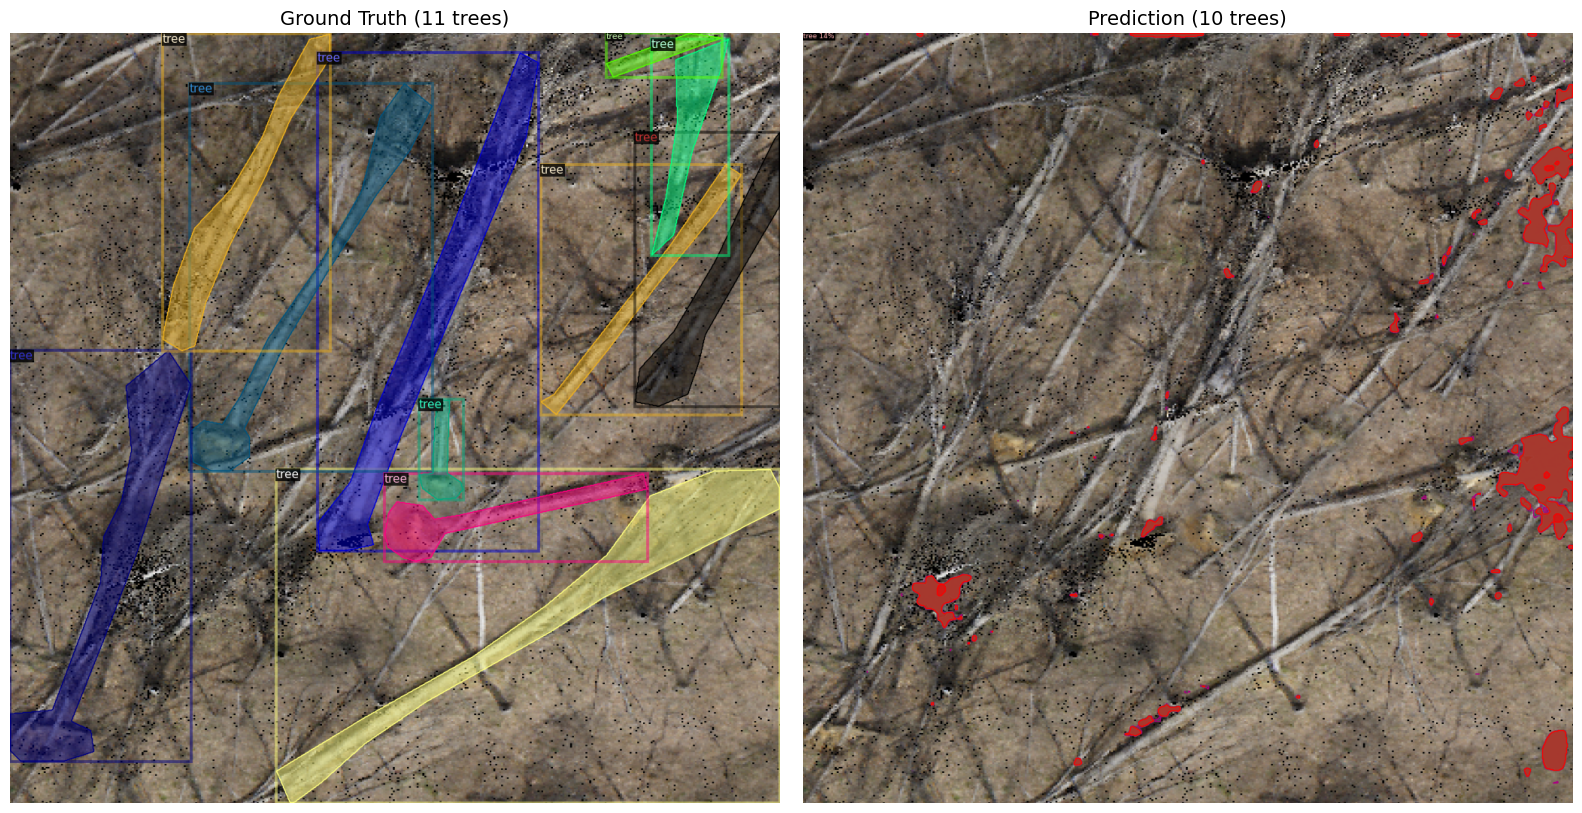

✅ Visualization saved!

⚠️  Note: Quality will be poor (only 100 iterations, no pretrained weights)
   This is expected for a quick test!


In [ ]:
# Verify Output Files

print("\n" + "="*70)
print("VERIFYING OUTPUT")
print("="*70 + "\n")

expected_files = ["model_final.pth", "config.yaml", "metrics.json"]

print("📁 Checking output files...")
for filename in expected_files:
    filepath = os.path.join(OUTPUT_DIR, filename)
    if os.path.exists(filepath):
        size = os.path.getsize(filepath) / (1024 * 1024)
        print(f"   ✅ {filename} ({size:.2f} MB)")
    else:
        print(f"   ❌ {filename} - NOT FOUND")

print("\n" + "="*70)
print("🎉 PIPELINE TEST COMPLETE!")
print("="*70)
print("\n✅ What we verified:")
print("   ✓ GPU is working")
print("   ✓ Mask2Former compiles on GPU")
print("   ✓ Dataset loads correctly")
print("   ✓ Training loop runs without errors")
print("   ✓ Model checkpoints save properly")

print("\n🚀 READY FOR FULL TRAINING!")
print("\n📋 To train the real model:")
print("   1. Use full dataset (487 train, 165 val)")
print("   2. Train for 10,000 iterations")
print("   3. Use batch size 4-8")
print("   4. Use image size 1024x1024")
print("   5. Load pretrained COCO weights")
print("   6. Expected time: 6-8 hours on T4 GPU")
print("="*70 + "\n")


# Quick Visualization (Optional)

print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70 + "\n")

import cv2
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine import DefaultPredictor

# Setup predictor
cfg.MODEL.WEIGHTS = os.path.join(OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
predictor = DefaultPredictor(cfg)

# Get a random validation image
val_sample = random.choice(val_dicts)
img = cv2.imread(val_sample["file_name"])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Make prediction
outputs = predictor(img)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Ground truth
v_gt = Visualizer(img_rgb, metadata=MetadataCatalog.get(VAL_DATASET_NAME), scale=1.0)
vis_gt = v_gt.draw_dataset_dict(val_sample)
axes[0].imshow(vis_gt.get_image())
axes[0].set_title(f"Ground Truth ({len(val_sample['annotations'])} trees)", fontsize=14)
axes[0].axis('off')

# Prediction
v_pred = Visualizer(img_rgb, metadata=MetadataCatalog.get(VAL_DATASET_NAME),
                    scale=1.0, instance_mode=ColorMode.IMAGE)
vis_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))
axes[1].imshow(vis_pred.get_image())
axes[1].set_title(f"Prediction ({len(outputs['instances'])} trees)", fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "test_prediction.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Visualization saved!")
print(f"\n⚠️  Note: Quality will be poor (only 100 iterations, no pretrained weights)")
print(f"   This is expected for a quick test!")


# FULL TRAINING CONFIGURATION

In [ ]:

import torch
import gc
import os

# Clear all GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    gc.collect()

    print(f"🔧 GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory cleared")

    # Check memory
    memory_allocated = torch.cuda.memory_allocated(0) / 1e9
    memory_reserved = torch.cuda.memory_reserved(0) / 1e9
    print(f"   Allocated: {memory_allocated:.2f} GB")
    print(f"   Reserved: {memory_reserved:.2f} GB")
    print(f"   Available: {15 - memory_reserved:.2f} GB")

# Set environment variable for better memory management
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
print(f"\n✅ Environment configured for better memory management")

# Verify datasets are still registered
from detectron2.data import DatasetCatalog
if "tree_train_full" in DatasetCatalog.list():
    train_dicts = DatasetCatalog.get("tree_train_full")
    val_dicts = DatasetCatalog.get("tree_val_full")
    print(f"\n📊 Datasets still registered:")
    print(f"   Train: {len(train_dicts)} images")
    print(f"   Val: {len(val_dicts)} images")
else:
    print("\n⚠️  Need to re-run dataset registration cell!")

print("\n✅ Ready for optimized configuration")


CLEAN RESTART

🔧 GPU: Tesla T4
   Memory cleared
   Allocated: 0.78 GB
   Reserved: 0.90 GB
   Available: 14.10 GB

✅ Environment configured for better memory management
[10/26 09:06:45 d2.data.datasets.coco]: Loaded 487 images in COCO format from /content/drive/MyDrive/mask2former_task/coco_format/instances_train.json
[10/26 09:06:45 d2.data.datasets.coco]: Loaded 165 images in COCO format from /content/drive/MyDrive/mask2former_task/coco_format/instances_val.json

📊 Datasets still registered:
   Train: 487 images
   Val: 165 images

✅ Ready for optimized configuration


In [ ]:
# OPTIMIZED CONFIGURATION

print("\n" + "="*70)
print("OPTIMIZED CONFIGURATION FOR T4 GPU")
print("="*70 + "\n")

import os
import torch
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from mask2former import add_maskformer2_config

WORK_DIR = "/content/drive/MyDrive/mask2former_task"
OUTPUT_DIR = f"{WORK_DIR}/output_full_training_v2"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Initialize config
cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)

# Load base config
os.chdir('/content/Mask2Former')
cfg.merge_from_file(
    "configs/coco/instance-segmentation/maskformer2_R50_bs16_50ep.yaml"
)

# Dataset
cfg.DATASETS.TRAIN = ("tree_train_full",)
cfg.DATASETS.TEST = ("tree_val_full",)
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 1

# Model - use ImageNet weights (from previous step)
weights_path = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
cfg.MODEL.WEIGHTS = weights_path
cfg.MODEL.DEVICE = "cuda"

print("📊 Dataset:")
print(f"   Train: {len(train_dicts)} images")
print(f"   Val: {len(val_dicts)} images")

print(f"\n🔧 Model:")
print(f"   Pretrained: ImageNet R-50 (backbone only)")

# CRITICAL MEMORY OPTIMIZATIONS
cfg.SOLVER.IMS_PER_BATCH = 2  # Reduced from 4
cfg.DATALOADER.NUM_WORKERS = 2

cfg.INPUT.MIN_SIZE_TRAIN = (800,)  # Reduced from 1024
cfg.INPUT.MAX_SIZE_TRAIN = 800
cfg.INPUT.MIN_SIZE_TEST = 800
cfg.INPUT.MAX_SIZE_TEST = 800
cfg.INPUT.RANDOM_FLIP = "horizontal"

cfg.MODEL.MASK_FORMER.NUM_OBJECT_QUERIES = 50  # Reduced from 100

print(f"\n💾 Memory Optimizations:")
print(f"   Batch size: 2 (fits in 15GB)")
print(f"   Image size: 800x800")
print(f"   Object queries: 50")

# Training parameters - adjusted for smaller batch
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 30000  # More iterations to compensate
cfg.SOLVER.STEPS = (20000, 26000)
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 2000

cfg.SOLVER.CHECKPOINT_PERIOD = 2000
cfg.TEST.EVAL_PERIOD = 0  # CRITICAL: Disable periodic eval to avoid hook error

# Gradient clipping
cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 0.01
cfg.SOLVER.CLIP_GRADIENTS.NORM_TYPE = 2.0

# AMP
cfg.SOLVER.AMP.ENABLED = True

print(f"\n⚙️ Training:")
print(f"   Iterations: {cfg.SOLVER.MAX_ITER:,}")
print(f"   Learning rate: {cfg.SOLVER.BASE_LR}")
print(f"   Checkpoints: every {cfg.SOLVER.CHECKPOINT_PERIOD} iters")
print(f"   Evaluation: at end only (periodic disabled)")

# Mask format
cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = False
cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = False

cfg.OUTPUT_DIR = OUTPUT_DIR

# Save config
with open(os.path.join(OUTPUT_DIR, "config.yaml"), "w") as f:
    f.write(cfg.dump())

# Estimates
iterations_per_epoch = len(train_dicts) // cfg.SOLVER.IMS_PER_BATCH
epochs = cfg.SOLVER.MAX_ITER / iterations_per_epoch
estimated_hours = cfg.SOLVER.MAX_ITER * 2.0 / 3600

print(f"\n⏱️ Estimates:")
print(f"   Iterations/epoch: ~{iterations_per_epoch}")
print(f"   Total epochs: ~{epochs:.1f}")
print(f"   Time: ~{estimated_hours:.1f} hours")

print(f"\n💾 Output: {OUTPUT_DIR}")
print("\n✅ Configuration complete!")


OPTIMIZED CONFIGURATION FOR T4 GPU

📊 Dataset:
   Train: 487 images
   Val: 165 images

🔧 Model:
   Pretrained: ImageNet R-50 (backbone only)

💾 Memory Optimizations:
   Batch size: 2 (fits in 15GB)
   Image size: 800x800
   Object queries: 50

⚙️ Training:
   Iterations: 30,000
   Learning rate: 0.0001
   Checkpoints: every 2000 iters
   Evaluation: at end only (periodic disabled)

⏱️ Estimates:
   Iterations/epoch: ~243
   Total epochs: ~123.5
   Time: ~16.7 hours

💾 Output: /content/drive/MyDrive/mask2former_task/output_full_training_v2

✅ Configuration complete!


In [ ]:
# INITIALIZE TRAINER (OPTIMIZED)

print("\n" + "="*70)
print("INITIALIZING TRAINER")
print("="*70 + "\n")

import torch
import gc

# Clear memory
torch.cuda.empty_cache()
gc.collect()

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data import transforms as T

class Mask2FormerTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, output_dir=output_folder, tasks=("segm",))

    @classmethod
    def build_train_loader(cls, cfg):
        from detectron2.structures import BitMasks

        def custom_mapper(dataset_dict):
            mapper = DatasetMapper(
                cfg,
                is_train=True,
                augmentations=[
                    T.ResizeShortestEdge(
                        cfg.INPUT.MIN_SIZE_TRAIN,
                        cfg.INPUT.MAX_SIZE_TRAIN,
                        "choice"
                    ),
                    T.RandomFlip(),
                ],
                image_format=cfg.INPUT.FORMAT,
                use_instance_mask=True,
                instance_mask_format="bitmask"
            )

            dataset_dict = mapper(dataset_dict)

            if "instances" in dataset_dict:
                instances = dataset_dict["instances"]
                if hasattr(instances, "gt_masks") and isinstance(instances.gt_masks, BitMasks):
                    instances.gt_masks = instances.gt_masks.tensor

            return dataset_dict

        return build_detection_train_loader(cfg, mapper=custom_mapper)

print("🔨 Creating trainer...")
trainer = Mask2FormerTrainer(cfg)

print("📥 Loading weights...")
try:
    trainer.resume_or_load(resume=False)
    print("✅ Weights loaded!")
except Exception as e:
    print(f"⚠️  Issue: {str(e)[:100]}")

# Check memory
memory_allocated = torch.cuda.memory_allocated(0) / 1e9
memory_reserved = torch.cuda.memory_reserved(0) / 1e9

print(f"\n💾 GPU Memory:")
print(f"   Allocated: {memory_allocated:.2f} GB")
print(f"   Reserved: {memory_reserved:.2f} GB")
print(f"   Free: {15 - memory_reserved:.2f} GB")

if memory_reserved > 12:
    print(f"\n⚠️  WARNING: High memory usage before training!")
    print(f"   Consider reducing batch size further if OOM occurs")

print(f"\n✅ Trainer ready!")


INITIALIZING TRAINER

🔨 Creating trainer...
[10/26 09:06:57 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBa

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:474: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()
R-50.pkl: 102MB [00:00, 219MB/s]                            


[10/26 09:06:58 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[10/26 09:06:58 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone - Total num: 54


criterion.empty_weight
sem_seg_head.pixel_decoder.adapter_1.norm.{bias, weight}
sem_seg_head.pixel_decoder.adapter_1.weight
sem_seg_head.pixel_decoder.input_proj.0.0.{bias, weight}
sem_seg_head.pixel_decoder.input_proj.0.1.{bias, weight}
sem_seg_head.pixel_decoder.input_proj.1.0.{bias, weight}
sem_seg_head.pixel_decoder.input_proj.1.1.{bias, weight}
sem_seg_head.pixel_decoder.input_proj.2.0.{bias, weight}
sem_seg_head.pixel_decoder.input_proj.2.1.{bias, weight}
sem_seg_head.pixel_decoder.layer_1.norm.{bias, weight}
sem_seg_head.pixel_decoder.layer_1.weight
sem_seg_head.pixel_decoder.mask_features.{bias, weight}
sem_seg_head.pixel_decoder.transformer.encoder.layers.0.linear1.{bias, weight}
sem_seg_head.pixel_decoder.transformer.encoder.layers.0.linear2.{bias, weight}
sem_seg_head.pixel_decoder.transformer.encoder.layers.0.norm1.{bias, weight}
sem_seg_head.pixel_decoder.transformer.encoder.layers.0.norm2.{bias, weight}
sem_seg_head.pixel_decoder.transformer.encoder.layers.0.self_attn.att

✅ Weights loaded!

💾 GPU Memory:
   Allocated: 0.42 GB
   Reserved: 0.98 GB
   Free: 14.02 GB

✅ Trainer ready!


In [ ]:
# START TRAINING (FINAL VERSION)

print("\n" + "="*70)
print("🚀 STARTING TRAINING")
print("="*70 + "\n")

print("📋 Final Configuration:")
print(f"   Images: {len(train_dicts)} train, {len(val_dicts)} val")
print(f"   Batch size: {cfg.SOLVER.IMS_PER_BATCH}")
print(f"   Image size: {cfg.INPUT.MIN_SIZE_TRAIN[0]}x{cfg.INPUT.MAX_SIZE_TRAIN}")
print(f"   Iterations: {cfg.SOLVER.MAX_ITER:,}")
print(f"   Checkpoints: every {cfg.SOLVER.CHECKPOINT_PERIOD} iters")
print(f"   Time estimate: ~{estimated_hours:.1f} hours")

print(f"\n💾 Output: {OUTPUT_DIR}")

print("\n✅ Optimizations:")
print("   ✓ Memory optimized for T4 GPU")
print("   ✓ Periodic evaluation disabled")
print("   ✓ Gradient clipping enabled")
print("   ✓ AMP enabled")

print("\n⚠️  Keep tab open during training!")
print("   To resume if interrupted: trainer.resume_or_load(resume=True)")

print("\n" + "="*70)
print("Starting in 3 seconds...")
print("="*70 + "\n")

import time
time.sleep(3)

# Final memory clear
torch.cuda.empty_cache()
gc.collect()

start_time = time.time()

try:
    trainer.train()

    elapsed_time = time.time() - start_time
    elapsed_hours = elapsed_time / 3600

    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"\n⏱️  Time: {elapsed_hours:.2f} hours")
    print(f"📁 Model: {OUTPUT_DIR}/model_final.pth")

    # Now run evaluation manually
    print("\n📊 Running final evaluation...")
    from detectron2.evaluation import inference_on_dataset
    from detectron2.data import build_detection_test_loader

    evaluator = COCOEvaluator("tree_val_full", output_dir=f"{OUTPUT_DIR}/eval")
    val_loader = build_detection_test_loader(cfg, "tree_val_full")
    results = inference_on_dataset(trainer.model, val_loader, evaluator)

    print("\n📊 Final Results:")
    print(f"   AP: {results['segm']['AP']:.2f}%")
    print(f"   AP50: {results['segm']['AP50']:.2f}%")
    print(f"   AP75: {results['segm']['AP75']:.2f}%")

    print("\n" + "="*70)

except KeyboardInterrupt:
    print("\n⚠️ Training interrupted")
    print(f"Resume: trainer.resume_or_load(resume=True)")

except torch.cuda.OutOfMemoryError as e:
    print(f"\n❌ Out of Memory!")
    print(f"   Try reducing batch size to 1")
    print(f"   Or image size to 640")

except Exception as e:
    print(f"\n❌ Error: {str(e)}")
    import traceback
    traceback.print_exc()

In [ ]:
trainer.resume_or_load(resume=True)